#### EXERCÍCIO AVALIATIVO 03: Propriedades Ising 2D

In [58]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [2]:
def initialize_lattice(size, initial_state):
    if initial_state == 'random':
        return 2 * np.random.randint(2, size=(size, size)) - 1
    elif initial_state == 'aligned':
        return np.ones((size, size), dtype=int)
    else:
        raise ValueError("Invalid value for beta. Use 0 or np.inf.")

In [3]:
def calculate_energy(lattice, i, j):
    size = lattice.shape[0]
    spin = lattice[i, j]
    neighbors_sum = lattice[(i + 1) % size, j] + lattice[i, (j + 1) % size] + \
                    lattice[(i - 1) % size, j] + lattice[i, (j - 1) % size]
    return -spin * neighbors_sum

In [4]:
def calculate_magnetization(lattice):
    return np.sum(lattice)

In [5]:
def metropolis(lattice, temperature):
    size = lattice.shape[0]
    i, j = np.random.randint(0, size, size=2)
    current_energy = calculate_energy(lattice, i, j)
    flip_spin = -lattice[i, j]
    new_energy = calculate_energy(lattice, i, j)

    if new_energy < current_energy or np.random.rand() < np.exp((current_energy - new_energy) / temperature):
        lattice[i, j] = flip_spin

In [6]:
def find_thermalization_steps(lattice, temperature, threshold=0.01, max_steps=5000):
    prev_energy = 0.5 * np.sum(-lattice * (np.roll(lattice, 1, axis=0) + np.roll(lattice, 1, axis=1)))

    for step in range(max_steps):
        metropolis(lattice, temperature)
        energy = 0.5 * np.sum(-lattice * (np.roll(lattice, 1, axis=0) + np.roll(lattice, 1, axis=1)))

        if np.abs(energy - prev_energy) < threshold:
            return step

        prev_energy = energy

    return max_steps

In [7]:
def ising_model_simulation(size, temperature, num_steps, initial_state):
    lattice = initialize_lattice(size, initial_state)
    energies = np.zeros(num_steps)
    magnetizations = np.zeros(num_steps)

    thermalization_steps = find_thermalization_steps(lattice, temperature)
    #print(f'Thermalization steps: {thermalization_steps}')

    for step in range(num_steps):
        metropolis(lattice, temperature)
        energy = 0.5 * np.sum(-lattice * (np.roll(lattice, 1, axis=0) + np.roll(lattice, 1, axis=1)))
        magnetization = calculate_magnetization(lattice)

        energies[step] = energy
        magnetizations[step] = magnetization

    return lattice, energies, magnetizations

In [8]:
def specific_heat(energies, temperature, N):
    return (np.average(np.power(energies, 2)) - np.power(np.average(energies), 2)) / (
        N * np.power(temperature, 2))

In [9]:
def susceptibility(magnetizations, temperature, N):
    return (np.average(np.power(magnetizations, 2)) - np.power(np.average(magnetizations), 2)) / (N * temperature)

In [10]:
def error(arr):
    return np.sqrt(
        np.sum(np.power(arr - np.average(arr), 2)) / (arr.size * (arr.size - 1))
    )

In [11]:
def metrics(step, safe, mc_steps, temperature, numSpins, energies, magnetizations,):
    energies_att = np.array([energy for energy in energies[safe:]])
    
    magnetizations_mod = np.abs(magnetizations)
    magnetizations_att = np.array([magnetization for magnetization in magnetizations_mod[safe:]])
    
    batches = int((mc_steps - safe) / step)
    tensor = np.zeros((batches, 4))
    
    for j in range(0, mc_steps - safe, step):
        cal = specific_heat(energies_att[j : j + step], temperature, numSpins)
        sus = susceptibility(magnetizations_att[j : j + step], temperature, numSpins)
        
        ene = np.average(energies_att[j : j + step]) / numSpins
        mag = np.average(magnetizations_att[j : j + step]) / numSpins
        
        tensor[int(j / step)] = np.array([cal, sus, ene, mag])

    matrix = tensor.T
    erro_cal = error(matrix[0])
    erro_sus = error(matrix[1])
    erro_ene = error(matrix[2])
    erro_mag = error(matrix[3])
    errors = np.array([erro_cal, erro_sus, erro_ene, erro_mag])
    
    m = [np.average(matrix, axis=0) for matrix in tensor]

    return m, errors

#### 01. Escolha dos parâmetros: motivação

#### 02. Comportamento das principais grandezas termodinâmicas

**02.1 Calor específico e susceptibilidade magnética em função da temperatura**

In [14]:
size = 32
t_base = 1.0
n_exp = 20
T = np.linspace(-2, 2, n_exp)
L = np.linspace(32, 100, n_exp)
num_steps = 1000
N = 1
PARTITION = 100
SAFETY_NUM = 500

In [15]:
plt.figure(1)
plt.figure(2);

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

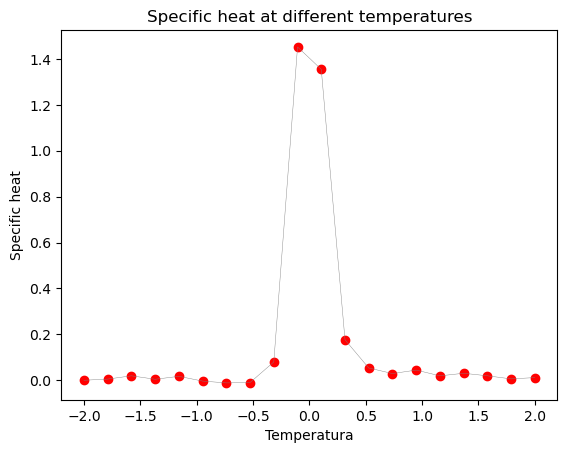

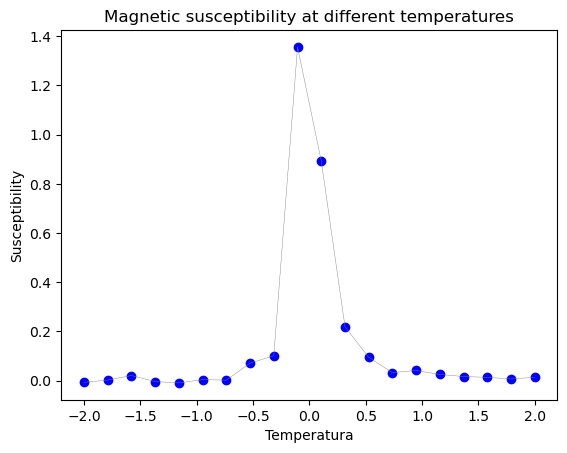

In [17]:
m_vec_t = []
e_vec_t = []

for i, t in enumerate(T):
    # Simulation for equally distributed spins initial state
    lattice_random, energies_random, magnetizations_random = ising_model_simulation(
        size, t, num_steps, initial_state='random')
    
    num_spins = np.power(size,2)
    
    m, e = metrics(PARTITION,
                   SAFETY_NUM,
                   num_steps,
                   t,
                   num_spins,
                   energies_random,
                   magnetizations_random,)
    
    m_vec_t.append(m)
    e_vec_t.append(e)
     
    
    # Plot energy for current temperature
    plt.figure(1)
    plt.scatter(t, m[0], color='Red')
    # Plot magnetization current temperature
    plt.figure(2)
    plt.scatter(t, m[1], color='Blue')
    

# Set plot labels and title
plt.figure(1)
heat_vec = [row[0] for row in m_vec_t]
plt.plot(T, heat_vec, color='gray', linewidth=0.3)
plt.title(f'Specific heat at different temperatures')
plt.xlabel('Temperatura')
plt.ylabel('Specific heat')

plt.figure(2)
mag_vec = [row[1] for row in m_vec_t]
plt.plot(T, mag_vec, color='gray', linewidth=0.3)
plt.title(f'Magnetic susceptibility at different temperatures')
plt.xlabel('Temperatura')
plt.ylabel('Susceptibility')

plt.show()

##### 03. Variação com o Tamanho do Sistema

In [ ]:
plt.figure(1)
plt.figure(2);

In [18]:
t = 1.0

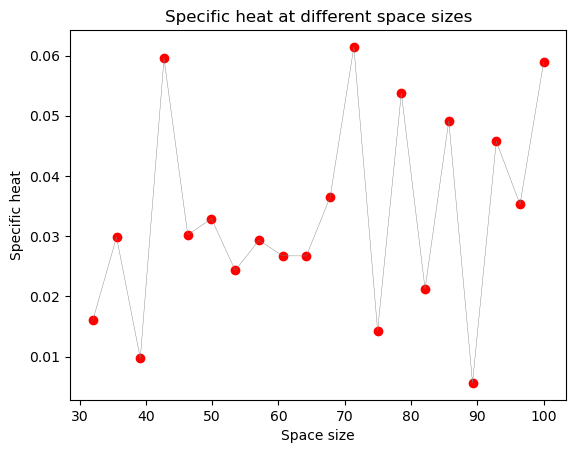

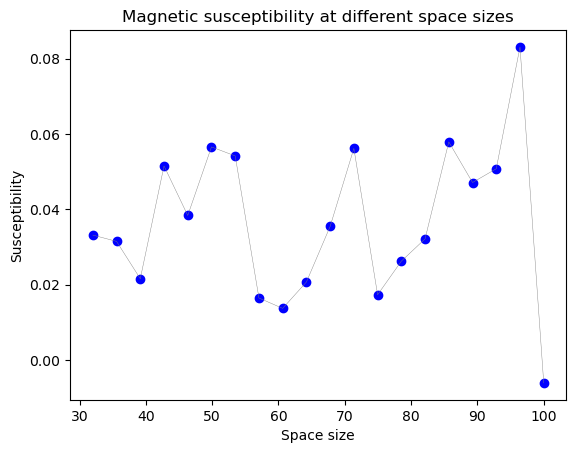

In [19]:
m_vec_l = []
e_vec_l = []

for i, l in enumerate(L):
    # Simulation for equally distributed spins initial state
    lattice_random, energies_random, magnetizations_random = ising_model_simulation(
        int(l), t, num_steps, initial_state='random')
    
    num_spins = np.power(size,2)
    
    m, e = metrics(PARTITION,
                   SAFETY_NUM,
                   num_steps,
                   t,
                   num_spins,
                   energies_random,
                   magnetizations_random,)
    
    m_vec_l.append(m)
    e_vec_l.append(e)
     
    
    # Plot energy for current temperature
    plt.figure(1)
    plt.scatter(l, m[0], color='Red')
    # Plot magnetization current temperature
    plt.figure(2)
    plt.scatter(l, m[1], color='Blue')
    

# Set plot labels and title
plt.figure(1)
heat_vec = [row[0] for row in m_vec_l]
plt.plot(L, heat_vec, color='gray', linewidth=0.3)
plt.title(f'Specific heat at different space sizes')
plt.xlabel('Space size')
plt.ylabel('Specific heat')

plt.figure(2)
mag_vec = [row[1] for row in m_vec_l]
plt.plot(L, mag_vec, color='gray', linewidth=0.3)
plt.title(f'Magnetic susceptibility at different space sizes')
plt.xlabel('Space size')
plt.ylabel('Susceptibility')

plt.show()

##### 04. Comportamento dos erros estatísticos:

In [ ]:
plt.figure(1)
plt.figure(2);

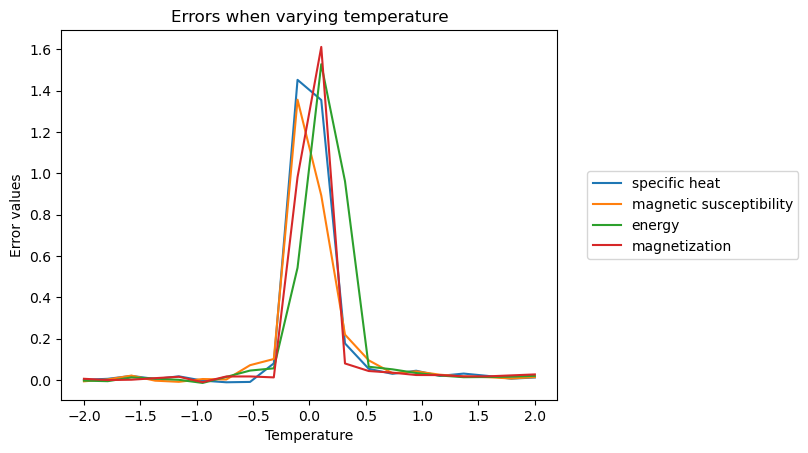

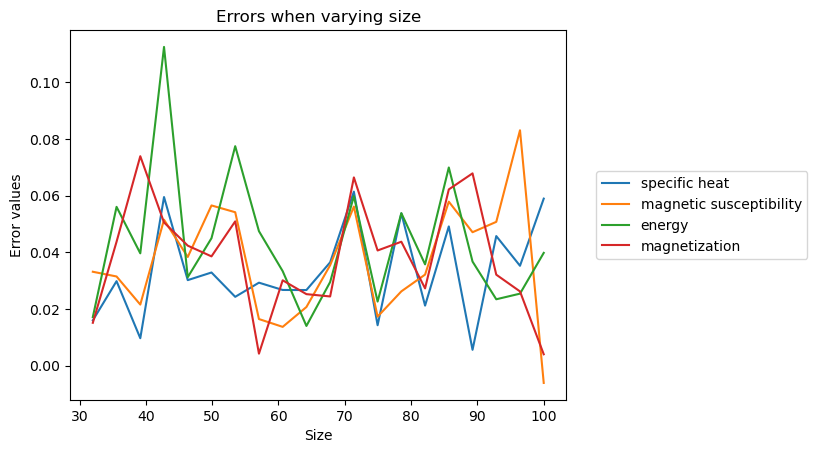

In [54]:
plt.figure(1)
plt.plot(T, [row[0] for row in m_vec_t], label='specific heat')
plt.plot(T, [row[1] for row in m_vec_t], label='magnetic susceptibility')
plt.plot(T, [row[2] for row in m_vec_t], label='energy')
plt.plot(T, [row[3] for row in m_vec_t], label='magnetization')
plt.title(f'Errors when varying temperature')
plt.xlabel('Temperature')
plt.ylabel('Error values')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.figure(2)
plt.plot(L, [row[0] for row in m_vec_l], label='specific heat')
plt.plot(L, [row[1] for row in m_vec_l], label='magnetic susceptibility')
plt.plot(L, [row[2] for row in m_vec_l], label='energy')
plt.plot(L, [row[3] for row in m_vec_l], label='magnetization')
plt.title(f'Errors when varying size')
plt.xlabel('Size')
plt.ylabel('Error values')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.show()
    

**0.5 Fases do sistema e temperatura de transição**

**06. Temperatura de transição do sistema no limite termodinâmico**

In [56]:
def mean_field_approximation(temperature, coupling_constant):
    return temperature - 2 * coupling_constant * np.tanh(1 / temperature)

In [71]:
coupling_constant = 1.0  # Interaction strength

# Range of temperatures
temperatures = np.linspace(0.01, 5.0, 100)

# Calculate the mean-field approximation for each temperature
mean_field_results = mean_field_approximation(temperatures, coupling_constant)

# Estimate the transition temperature using scipy's fsolve
transition_temperature_estimate = fsolve(mean_field_approximation, 2.0, args=(coupling_constant,))

print("Transition temperature estiamte:", transition_temperature_estimate[0])

Transition temperature estiamte: 1.2958364580592054


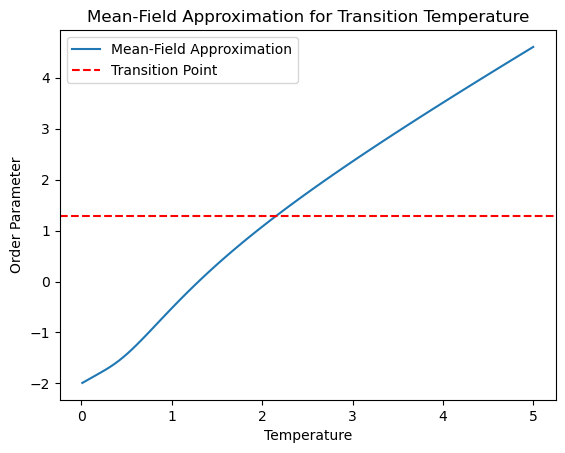

In [70]:
# Plot the results
plt.plot(temperatures, mean_field_results, label='Mean-Field Approximation')
plt.axhline(transition_temperature_estimate[0], color='red', linestyle='--', label='Transition Point')
plt.xlabel('Temperature')
plt.ylabel('Order Parameter')
plt.title('Mean-Field Approximation for Transition Temperature')
plt.legend()
plt.show()